
-----
#### MS: Unique patterns of mutations in childhood cancer highlight chemotherapy’s disease-defining role at relapse
### Extended Data Figure 4
-----

In [2]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import os
import sys

A_col = "#3288BD"
B_col = "#D53E4F"

-----
##### Set up input / output directories

In [3]:
## Provide an output directory for figures or use 'installation_folder/figures' directory
root_dir = os.path.dirname(os.getcwd())
fig_out = os.path.join(root_dir, 'figures')
## Or provide a results path
#fig_out = '/Users/dir1/dir2/Figures'

-----
##### Load helper scripts

In [4]:
sys.path.append(str(root_dir))
import scripts.plotter as plotter

-----
##### Load & prepare data 

In [5]:
## Load patients metadata
kzm611_md = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_md.tsv'), sep='\t', index_col=0)
low_samples = kzm611_md[kzm611_md.Burden=='low'].index.tolist()

In [6]:
kzm611_sigs = pd.read_csv(os.path.join(root_dir, 'source_data/KZM_signatures.tsv'), sep='\t', index_col=0)
kzm611_sigs_low = kzm611_sigs.loc[low_samples].copy()
kzm611_sigs.shape, kzm611_sigs_low.shape

((611, 70), (577, 70))

In [7]:
(kzm611_sigs_low.SBS31.sum() + kzm611_sigs_low.SBS35.sum()), (kzm611_sigs_low.SBS31.sum() + kzm611_sigs_low.SBS35.sum()) / kzm611_sigs_low[[x for x in kzm611_sigs_low.columns if x.startswith('SBS')]].sum().sum()

(235519, 0.09679441128264647)

In [8]:
kzm611_sigs.DBS5.sum(), kzm611_sigs.DBS5.sum() / kzm611_sigs[[x for x in kzm611_sigs.columns if x.startswith('DBS')]].sum().sum()

(3328.0, 0.05045405618471521)

In [9]:
kzm611_sigs_low.DBS5.sum(), kzm611_sigs_low.DBS5.sum() / kzm611_sigs_low[[x for x in kzm611_sigs_low.columns if x.startswith('DBS')]].sum().sum()

(2693.0, 0.13495364570283136)

In [89]:
kzm611_sigs[(kzm611_sigs.SBS31>0) | (kzm611_sigs.SBS35>0) | (kzm611_sigs.SBS288L5>0)].shape

(82, 69)

-----
## Panel a

In [54]:
def prepend(list, str): 
    str += '{0}'
    list = [str.format(i) for i in list] 
    return(list)

def plotTMB_generic_v3(inputDF, kzm611_sbs_rel, scale, order=[], Yrange = "adapt", cutoff = 0, output = "TMB_plot.png",
            redbar = "median", yaxis = "Somatic Mutations per Megabase",
            ascend = True, leftm = 1, rightm = 0.3, topm = 1.4, bottomm = 1):
    if type(scale) == int:
        scale = scale
    elif scale == "genome":
        scale  = 2897.310462
    elif scale == "exome":
        scale = 55
    else:
        print("Please input valid scale values: \"exome\", \"genome\" or a numeric value")
        return

    inputDF.columns = ['Types', 'Mut_burden']
    df=inputDF[inputDF["Mut_burden"] > cutoff].copy()
    df['log10BURDENpMB'] = df.apply(lambda row: np.log10(row.Mut_burden/scale), axis = 1)
    groups = df.groupby(["Types"])
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        if len(order) == 0:
            redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
            names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
        else:
            redbars = groups.median()["log10BURDENpMB"]
            redbars = redbars.loc[order]
            names = order
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return
    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups
    #second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]
    list1 = counts.to_list()
    list2 = input_counts.to_list()
    str1 = ''
    list3 = prepend(list1, str1)
    str2 = '\n'
    list4 = prepend(list2, str2)
    result = [None]*(len(list3)+len(list4))
    result[::2] = list3
    result[1::2] = list4
    tick_labels = result
    new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
    #new_labels = list3
    if Yrange == "adapt":
        ymax = math.ceil(df['log10BURDENpMB'].max())
        ymin = math.floor(df['log10BURDENpMB'].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        print("Yrange is a list")
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print("ERROR:Please input valid scale values: \"adapt\", \"cancer\" or a list of two power of 10 numbers")
        return
    #plotting
    if ngroups < 7:
        rightm = rightm + 0.4 * (7 - ngroups)
    if len(names[0])>13:
        leftm = leftm + 0.09 * (len(names[0]) - 13)
        topm = topm + 0.080 * (len(names[0]) - 13)
    fig_width = leftm + rightm + 0.4 * ngroups
    #fig_length = topm + bottomm + (ymax - ymin) * 0.7
    #print("{} -- {}".format(fig_width, fig_length))
    #fig_width = 4
    fig_length = 4
    fig, ax2 = plt.subplots(figsize=(fig_width, fig_length))

    
    #ax1 = kzm611_sbs_rel.plot(kind="bar", stacked=True, width=0.95, color=[A_col, B_col], ax=ax0)
    line_y = 1.3
    ann_y = 4.75
    trans = ax2.get_xaxis_transform()

    ax2.text(2, ann_y, 'Clock-like', fontsize=12, rotation=90)
    ax2.plot([0.4, 3.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(6, ann_y, 'APOBEC', fontsize=12, rotation=90)
    ax2.plot([4.4, 7.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(10, ann_y, 'UV', fontsize=12, rotation=90)
    ax2.plot([8.4, 11.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(13.5, ann_y, 'POLE', fontsize=12, rotation=90)
    ax2.plot([12.4, 15.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(16.6, ann_y, 'POLE/MMRD', fontsize=12, rotation=90)
    ax2.plot([16.4, 17.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(18.6, ann_y, 'POLD1/MMRD', fontsize=12, rotation=90)
    ax2.plot([18.4, 19.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(20.8, ann_y, 'Temo', fontsize=12, rotation=90)
    ax2.plot([20.4, 21.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(22.6, ann_y, '5-FU', fontsize=12, rotation=90)
    ax2.plot([22.4, 23.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(25.5, ann_y, 'Platinum', fontsize=12, rotation=90)
    ax2.plot([24.4, 27.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(28.6, ann_y, 'Thiopurine', fontsize=12, rotation=90)
    ax2.plot([28.4, 29.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(33, ann_y, 'Novel\nTherapy', fontsize=12, rotation=90)
    ax2.plot([30.4, 37.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(38.6, ann_y, 'AID', fontsize=12, rotation=90)
    ax2.plot([38.4, 39.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(41.6, ann_y, 'MMRD/MSI', fontsize=12, rotation=90)
    ax2.plot([40.4, 43.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(44.5, ann_y, 'ROS', fontsize=12, rotation=90)
    ax2.plot([44.4, 45.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(50, ann_y, 'Unknown', fontsize=12, rotation=90)
    ax2.plot([46.4, 55.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(60, ann_y, 'Novel', fontsize=12, rotation=90)
    ax2.plot([56.4, 65.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.text(73, ann_y, 'Artifacts', fontsize=12, rotation=90)
    ax2.plot([66.4, 79.8],[line_y,line_y], color="k", transform=trans, clip_on=False)

    ax2.plot([20, 38],[1,1], color="red", linewidth = 2, transform=trans, clip_on=False)
    ax2.plot([20, 38],[1.7,1.7], color="red", linewidth = 2, transform=trans, clip_on=False)
    ax2.plot([20, 20],[1,1.7], color="red", linewidth = 2, transform=trans, clip_on=False)
    ax2.plot([38, 38],[1,1.7], color="red", linewidth = 2, transform=trans, clip_on=False)

    ax2.text(24, 4.2, 'Therapy Signatures', color="red", fontsize=14)

    ax2.set_xlim(0,2*ngroups)
    ax2.set_ylim(ymin,ymax)
    yticks_loc = range(ymin,ymax+1,1)
    ax2.set_yticks(yticks_loc,list(map((lambda x: 10**x), list(yticks_loc))))
    ax2.set_xticks(np.arange(1, 2*ngroups+1, step = 2), new_labels) 
    ax2.tick_params(axis = 'both', which = 'both',length = 0)
    ax2.hlines(yticks_loc,0,2*ngroups,colors = 'black',linestyles = "dashed",linewidth = 0.5,zorder = 1)
    for i in range(0,ngroups,2):
        greystart = [(i)*2,ymin]
        rectangle = mpatches.Rectangle(greystart, 2, ymax-ymin, color = "lightgrey",zorder = 0)
        ax2.add_patch(rectangle)
    for i in range(0,ngroups,1):
        X_start = i*2+0.2
        X_end = i*2+2-0.2
        #rg = 1.8
        y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
        x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
        ax2.scatter(x_values,y_values,color = "black",s=1.5)
        ax2.hlines(redbars[i], X_start, X_end, colors='red', zorder=2)
        ax2.text((leftm + 0.2 + i * 0.4) / fig_width , 0.85 / fig_length , "___",  horizontalalignment='center',transform=plt.gcf().transFigure)
    ax2.set_ylabel(yaxis)

    axes2 = ax2.twiny()
    plt.tick_params(axis = 'both', which = 'both',length = 0)
    plt.xticks(np.arange(1, 2*ngroups+1, step = 2),names,rotation = 90,ha = 'right')

    fig.subplots_adjust(top = ((ymax - ymin) * 0.7 + bottomm) / fig_length, bottom = bottomm / fig_length, left = leftm / fig_width, right=1 - rightm / fig_width)


In [61]:
## Adapted from https://github.com/AlexandrovLab/SigProfilerPlotting
def plotTMB_DBS_v3(inputDF, kzm611_sbs_rel, scale, order=[], Yrange = "adapt", cutoff = 0,
            redbar = "median", yaxis = "Somatic Mutations per Megabase",
            ascend = True, leftm = 1, rightm = 0.3, topm = 1.4, bottomm = 1):
    """
    Same as plotTMB_SBS
    """
    if type(scale) == int:
        scale = scale
    elif scale == "genome":
        scale  = 2897.310462
    elif scale == "exome":
        scale = 55
    else:
        print("Please input valid scale values: \"exome\", \"genome\" or a numeric value")
        return

    inputDF.columns = ['Types', 'Mut_burden']
    df=inputDF[inputDF["Mut_burden"] > cutoff].copy()
    df['log10BURDENpMB'] = df.apply(lambda row: np.log10(row.Mut_burden/scale), axis = 1)
    groups = df.groupby(["Types"])
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        if len(order) == 0:
            redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
            names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
        else:
            redbars = groups.median()["log10BURDENpMB"]
            redbars = redbars.loc[order]
            names = order
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return
    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups
    #second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]
    list1 = counts.to_list()
    list2 = input_counts.to_list()
    str1 = ''
    list3 = prepend(list1, str1)
    str2 = '\n'
    list4 = prepend(list2, str2)
    result = [None]*(len(list3)+len(list4))
    result[::2] = list3
    result[1::2] = list4
    tick_labels = result
    new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
    if Yrange == "adapt":
        ymax = math.ceil(df['log10BURDENpMB'].max())
        ymin = math.floor(df['log10BURDENpMB'].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        print("Yrange is a list")
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print("ERROR:Please input valid scale values: \"adapt\", \"cancer\" or a list of two power of 10 numbers")
        return
    #plotting
    if ngroups < 7:
        rightm = rightm + 0.4 * (7 - ngroups)
    if len(names[0])>13:
        leftm = leftm + 0.09 * (len(names[0]) - 13)
        topm = topm + 0.080 * (len(names[0]) - 13)
    fig_width = leftm + rightm + 0.4 * ngroups
    fig_length = 4
    fig, ax2 = plt.subplots(figsize=(fig_width, fig_length))

    ann_y = 2.6
    ax2.text(1, ann_y, 'UV', fontsize=12, rotation=90)
    ax2.text(3, ann_y, 'Tobacco, etc.', fontsize=12, rotation=90)
    ax2.text(4.5, ann_y, 'Platinum', fontsize=12, rotation=90)
    ax2.text(7.5, ann_y, 'MMRD', fontsize=12, rotation=90)
    ax2.text(12.5, ann_y, 'Novel', fontsize=12, rotation=90)
    ax2.text(19.5, ann_y, 'Unknown', fontsize=12, rotation=90)

    line_y = 1.35
    trans = ax2.get_xaxis_transform()
    ax2.plot([0.4, 1.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([2.4, 3.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([4.4, 5.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([6.4, 9.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([10.4, 15.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([16.4, 23.4],[line_y,line_y], color="k", transform=trans, clip_on=False)


    if cutoff < 0:
        print("ERROR: cutoff value is less than 0")
        return
    ax2.set_xlim(0,2*ngroups)
    #print(len(names[0]))
    ax2.set_ylim(ymin,ymax)
    yticks_loc = range(ymin,ymax+1,1)
    ax2.set_yticks(yticks_loc,list(map((lambda x: 10**x), list(yticks_loc))))
    ax2.set_xticks(np.arange(1, 2*ngroups+1, step = 2), new_labels) 
    ax2.tick_params(axis = 'both', which = 'both',length = 0)
    ax2.hlines(yticks_loc,0,2*ngroups,colors = 'black',linestyles = "dashed",linewidth = 0.5,zorder = 1)
    for i in range(0,ngroups):
        if ((i+1) % 2) == 0:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color="white", zorder = 0)
            ax2.add_patch(rectangle)
        else:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color='lightgray', zorder = 0)
            ax2.add_patch(rectangle)
    for i in range(0,ngroups,1):
        X_start = i*2+0.2
        X_end = i*2+2-0.2
        y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
        x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
        ax2.scatter(x_values,y_values,color = "black",s=1.5)
        ax2.hlines(redbars[i], X_start, X_end, colors='red', zorder=2)
        ax2.text((leftm + 0.2 + i * 0.4) / fig_width , 0.85 / fig_length , "___",  horizontalalignment='center',transform=plt.gcf().transFigure)
    ax2.set_ylabel(yaxis)

    axes2 = ax2.twiny()
    plt.tick_params(axis = 'both', which = 'both',length = 0)
    plt.xticks(np.arange(1, 2*ngroups+1, step = 2),names,rotation = 90,ha = 'right')

    fig.subplots_adjust(top = ((ymax - ymin) * 0.7 + bottomm) / fig_length, bottom = bottomm / fig_length, left = leftm / fig_width, right=1 - rightm / fig_width)

In [12]:
kzm611_sbs = kzm611_sigs[[x for x in kzm611_sigs.columns if x.startswith('SBS')]].copy()
kzm611_sbs['samples'] = kzm611_sbs.index.tolist()
kzm611_sbs_mlt = pd.melt(kzm611_sbs, id_vars=['samples'], value_vars=kzm611_sbs.columns.tolist())
kzm611_sbs_mlt.columns = ['Samples', 'Signatures', 'Mutations']
kzm611_sbs_mlt['Treatment'] = [kzm611_md.loc[x, 'Therapy'] for x in kzm611_sbs_mlt.Samples]
kzm611_sbs_mlt.head()

,Samples,Signatures,Mutations,Treatment
0,I-H-108298-T1-1-D1-1,SBS1,0,Post-Therapy
1,I-H-108317-T1-1-D1-1,SBS1,571,Post-Therapy
2,I-H-108319-T1-1-D1-1,SBS1,0,Post-Therapy
3,I-H-108333-T2-2-D1-1,SBS1,434,Post-Therapy
4,I-H-121266-T1-2-D1-1,SBS1,227,Post-Therapy


In [13]:
sig_class = [['SBS1', 'SBS5'],
             ['SBS2', 'SBS13'],
             ['SBS7a', 'SBS7b'],
             ['SBS10a', 'SBS10b'],
             ['SBS14'],
             ['SBS20'],
             ['SBS11', 'SBS17b', 'SBS31', 'SBS35', 'SBS87'],
             ['SBS288L2', 'SBS288L3', 'SBS288L4', 'SBS288L5'],
             ['SBS84'],
             ['SBS15', 'SBS44'],
             ['SBS18'],
             ['SBS8', 'SBS12', 'SBS17a', 'SBS33', 'SBS39'],
             ['SBS288L1/H3', 'SBS288H1', 'SBS288H2', 'SBS288H4', 'SBS288H5'],
             ['SBS43', 'SBS45', 'SBS46', 'SBS53', 'SBS54', 'SBS57', 'SBS60']]
sbs_order = [x for sc in sig_class for x in sc]
sig_cats = ['Clock-like', 'APOBEC', 'UV', 'POLE', 'POLE/MMRD', 'POLD1/MMRD', 'Known\nTherapy', 'Novel\nTherapy', 'AID', 'MMRD/MSI', 'ROS', 'Unknown', 'Novel', 'Artifacts']

print(sbs_order)

['SBS1', 'SBS5', 'SBS2', 'SBS13', 'SBS7a', 'SBS7b', 'SBS10a', 'SBS10b', 'SBS14', 'SBS20', 'SBS11', 'SBS17b', 'SBS31', 'SBS35', 'SBS87', 'SBS288L2', 'SBS288L3', 'SBS288L4', 'SBS288L5', 'SBS84', 'SBS15', 'SBS44', 'SBS18', 'SBS8', 'SBS12', 'SBS17a', 'SBS33', 'SBS39', 'SBS288L1/H3', 'SBS288H1', 'SBS288H2', 'SBS288H4', 'SBS288H5', 'SBS43', 'SBS45', 'SBS46', 'SBS53', 'SBS54', 'SBS57', 'SBS60']


In [14]:
kzm611_sbs_piv = kzm611_sbs_mlt.pivot_table(values='Mutations', index='Signatures', columns='Treatment')
kzm611_sbs_piv = kzm611_sbs_piv.reindex(sbs_order)
kzm611_sbs_rel = kzm611_sbs_piv.div(kzm611_sbs_piv.sum(axis=1), axis=0)
kzm611_sbs_rel = kzm611_sbs_rel[['Pre-Therapy', 'Post-Therapy']]
kzm611_sbs_rel.head(2)

Treatment,Pre-Therapy,Post-Therapy
Signatures,,
SBS1,0.700763,0.299237
SBS5,0.612242,0.387758


/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/115917800.py:143: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/115917800.py:144: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/115917800.py:146: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

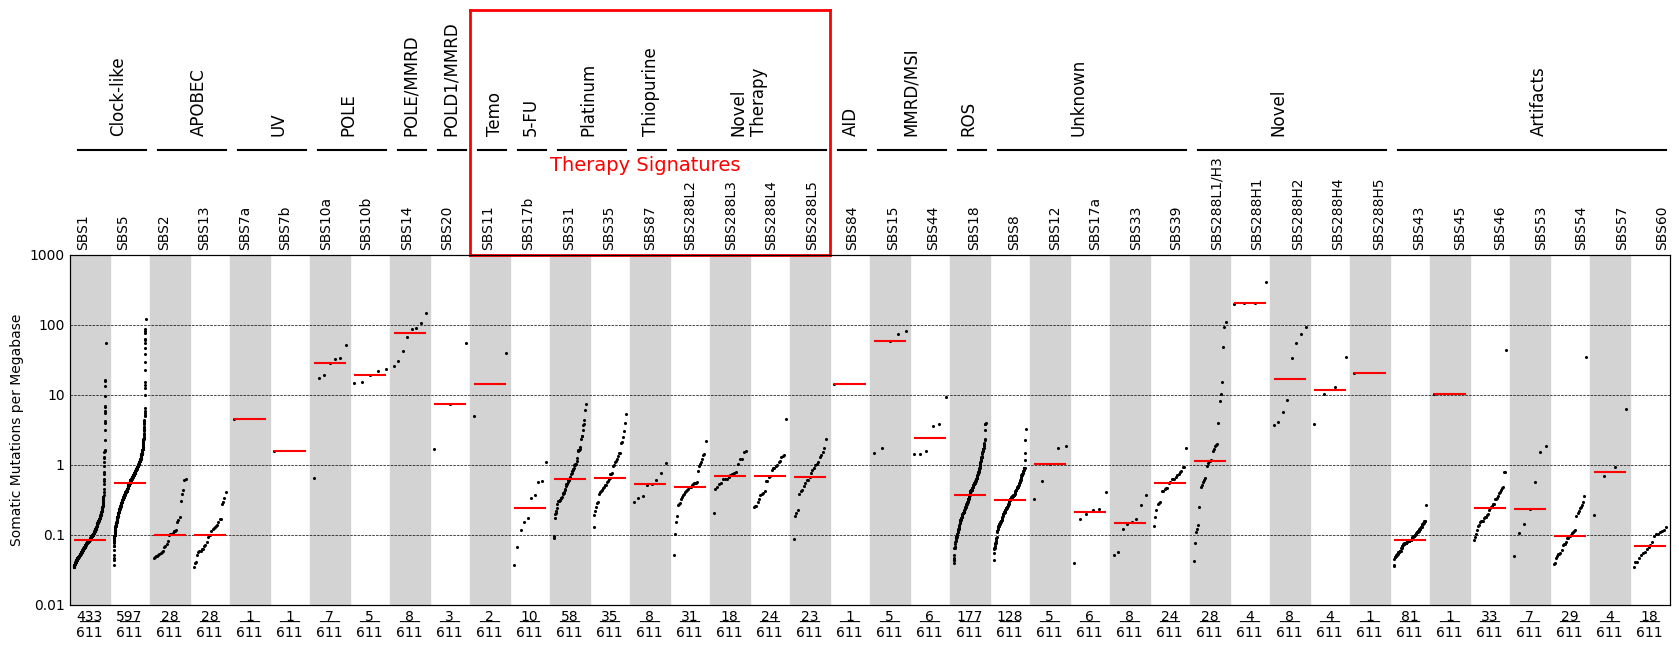

In [59]:
plotTMB_generic_v3(kzm611_sbs_mlt[['Signatures', 'Mutations']].copy(), kzm611_sbs_rel, order=sbs_order, scale='genome')
plt.savefig(os.path.join(fig_out, 'ExFig_4a_rev.pdf'), bbox_inches="tight")

-----
## Panel b

In [18]:
kzm611_dbs = kzm611_sigs[[x for x in kzm611_sigs.columns if x.startswith('DBS')]].copy()
kzm611_dbs['samples'] = kzm611_dbs.index.tolist()
kzm611_dbs_mlt = pd.melt(kzm611_dbs, id_vars=['samples'], value_vars=kzm611_dbs.columns.tolist())
kzm611_dbs_mlt.columns = ['Samples', 'Signatures', 'Mutations']
kzm611_dbs_mlt['Treatment'] = [kzm611_md.loc[x, 'Therapy'] for x in kzm611_dbs_mlt.Samples]
kzm611_dbs_mlt.head()

,Samples,Signatures,Mutations,Treatment
0,I-H-108298-T1-1-D1-1,DBS1,0.0,Post-Therapy
1,I-H-108317-T1-1-D1-1,DBS1,0.0,Post-Therapy
2,I-H-108319-T1-1-D1-1,DBS1,0.0,Post-Therapy
3,I-H-108333-T2-2-D1-1,DBS1,0.0,Post-Therapy
4,I-H-121266-T1-2-D1-1,DBS1,0.0,Post-Therapy


In [19]:
kzm611_dbs.columns

Index(['DBS1', 'DBS2', 'DBS4', 'DBS5', 'DBS6', 'DBS7', 'DBS9', 'DBS10',
       'DBS11', 'DBS78L1/H1', 'DBS78H2', 'DBS78H3', 'samples'],
      dtype='object')

In [20]:
dbs_order = ['DBS1', 'DBS2', 'DBS5', 'DBS7', 'DBS10',
             'DBS78L1/H1', 'DBS78H2', 'DBS78H3',
             'DBS4', 'DBS6', 'DBS9', 'DBS11']

In [21]:
kzm611_dbs_piv = kzm611_dbs_mlt.pivot_table(values='Mutations', index='Signatures', columns='Treatment')
kzm611_dbs_piv = kzm611_dbs_piv.reindex(dbs_order)
kzm611_dbs_rel = kzm611_dbs_piv.div(kzm611_dbs_piv.sum(axis=1), axis=0)
kzm611_dbs_rel = kzm611_dbs_rel[['Pre-Therapy', 'Post-Therapy']]
kzm611_dbs_rel.head(2)

Treatment,Pre-Therapy,Post-Therapy
Signatures,,
DBS1,0.761550,0.238450
DBS2,0.035679,0.964321


/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3342087929.py:114: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3342087929.py:115: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3342087929.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

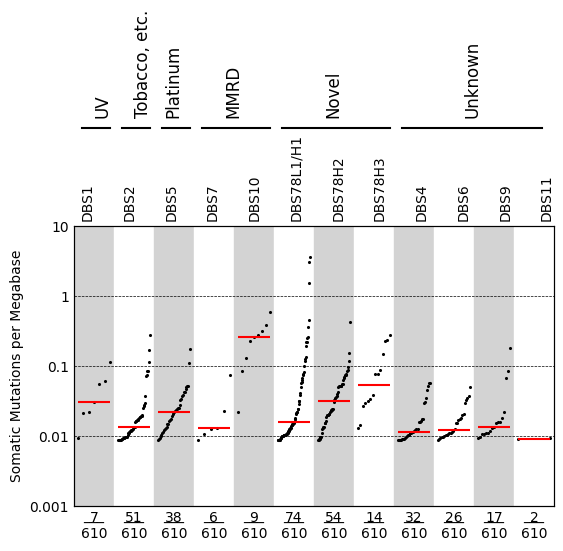

In [62]:
## plotDBS_generic_v2
plotTMB_DBS_v3(kzm611_dbs_mlt[['Signatures', 'Mutations']].copy(), kzm611_dbs_rel, order=dbs_order, scale='genome')
plt.savefig(os.path.join(fig_out, 'ExFig_4b_rev.pdf'), bbox_inches="tight")

-----
## Panel c

In [69]:
## Adapted from https://github.com/AlexandrovLab/SigProfilerPlotting
def plotTMB_ID_v3(inputDF, kzm611_sigs_rel, scale, order=[], Yrange = "adapt", cutoff = 0,
            redbar = "median", yaxis = "Somatic Mutations per Megabase",
            ascend = True, leftm = 1, rightm = 0.3, topm = 1.4, bottomm = 1):
    """
    Same as plotTMB_SBS
    """
    if type(scale) == int:
        scale = scale
    elif scale == "genome":
        scale  = 2897.310462
    elif scale == "exome":
        scale = 55
    else:
        print("Please input valid scale values: \"exome\", \"genome\" or a numeric value")
        return

    inputDF.columns = ['Types', 'Mut_burden']
    df=inputDF[inputDF["Mut_burden"] > cutoff].copy()
    df['log10BURDENpMB'] = df.apply(lambda row: np.log10(row.Mut_burden/scale), axis = 1)
    groups = df.groupby(["Types"])
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        if len(order) == 0:
            redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
            names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
        else:
            redbars = groups.median()["log10BURDENpMB"]
            redbars = redbars.loc[order]
            names = order
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return
    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups
    #second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]
    list1 = counts.to_list()
    list2 = input_counts.to_list()
    str1 = ''
    list3 = prepend(list1, str1)
    str2 = '\n'
    list4 = prepend(list2, str2)
    result = [None]*(len(list3)+len(list4))
    result[::2] = list3
    result[1::2] = list4
    tick_labels = result
    new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
    if Yrange == "adapt":
        ymax = math.ceil(df['log10BURDENpMB'].max())
        ymin = math.floor(df['log10BURDENpMB'].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        print("Yrange is a list")
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print("ERROR:Please input valid scale values: \"adapt\", \"cancer\" or a list of two power of 10 numbers")
        return
    #plotting
    if ngroups < 7:
        rightm = rightm + 0.4 * (7 - ngroups)
    if len(names[0])>13:
        leftm = leftm + 0.09 * (len(names[0]) - 13)
        topm = topm + 0.080 * (len(names[0]) - 13)
    fig_width = leftm + rightm + 0.4 * ngroups
    fig_length = 4
    fig, ax2 = plt.subplots(figsize=(fig_width, fig_length))

    ann_y = 4.35
    ax2.text(2.1, ann_y, 'MMRD/MSI', fontsize=12, rotation=90)
    ax2.text(4.8, ann_y, 'Tobacco', fontsize=12, rotation=90)
    ax2.text(6.8, ann_y, 'Radiation', fontsize=12, rotation=90)
    ax2.text(8.8, ann_y, 'Top2A', fontsize=12, rotation=90)
    ax2.text(18, ann_y, 'Novel', fontsize=12, rotation=90)
    ax2.text(30, ann_y, 'Unknown', fontsize=12, rotation=90)

    line_y = 1.23
    trans = ax2.get_xaxis_transform()
    ax2.plot([0.4, 3.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([4.4, 5.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([6.4, 7.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([8.4, 9.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([10.4, 25.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([26.4, 33.8],[line_y,line_y], color="k", transform=trans, clip_on=False)

    if cutoff < 0:
        print("ERROR: cutoff value is less than 0")
        return
    ax2.set_xlim(0,2*ngroups)
    ax2.set_ylim(ymin,ymax)
    yticks_loc = range(ymin,ymax+1,1)
    ax2.set_yticks(yticks_loc,list(map((lambda x: 10**x), list(yticks_loc))))
    ax2.set_xticks(np.arange(1, 2*ngroups+1, step = 2), new_labels) 
    ax2.tick_params(axis = 'both', which = 'both',length = 0)
    ax2.hlines(yticks_loc,0,2*ngroups,colors = 'black',linestyles = "dashed",linewidth = 0.5,zorder = 1)

    for i in range(0,ngroups):
        if ((i+1) % 2) == 0:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color="white", zorder = 0)
            ax2.add_patch(rectangle)
        else:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color='lightgray', zorder = 0)
            ax2.add_patch(rectangle)
    for i in range(0,ngroups,1):
        X_start = i*2+0.2
        X_end = i*2+2-0.2
        y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
        x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
        ax2.scatter(x_values,y_values,color = "black",s=1.5)
        ax2.hlines(redbars[i], X_start, X_end, colors='red', zorder=2)
        ax2.text((leftm + 0.2 + i * 0.4) / fig_width , 0.85 / fig_length , "___",  horizontalalignment='center',transform=plt.gcf().transFigure)
    ax2.set_ylabel(yaxis)

    axes2 = ax2.twiny()
    plt.tick_params(axis = 'both', which = 'both',length = 0)
    plt.xticks(np.arange(1, 2*ngroups+1, step = 2),names,rotation = 90,ha = 'right')

    fig.subplots_adjust(top = ((ymax - ymin) * 0.7 + bottomm) / fig_length, bottom = bottomm / fig_length, left = leftm / fig_width, right=1 - rightm / fig_width)

In [24]:
kzm611_id = kzm611_sigs[[x for x in kzm611_sigs.columns if x.startswith('ID')]].copy()
kzm611_id['samples'] = kzm611_id.index.tolist()
kzm611_id_mlt = pd.melt(kzm611_id, id_vars=['samples'], value_vars=kzm611_id.columns.tolist())
kzm611_id_mlt.columns = ['Samples', 'Signatures', 'Mutations']
kzm611_id_mlt['Treatment'] = [kzm611_md.loc[x, 'Therapy'] for x in kzm611_id_mlt.Samples]
kzm611_id_mlt.head()

,Samples,Signatures,Mutations,Treatment
0,I-H-108298-T1-1-D1-1,ID1,279,Post-Therapy
1,I-H-108317-T1-1-D1-1,ID1,484,Post-Therapy
2,I-H-108319-T1-1-D1-1,ID1,355,Post-Therapy
3,I-H-108333-T2-2-D1-1,ID1,303,Post-Therapy
4,I-H-121266-T1-2-D1-1,ID1,183,Post-Therapy


In [74]:
kzm611_id.columns

Index(['ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID8', 'ID9', 'ID12', 'ID17',
       'ID83L1', 'ID83I1', 'ID83I2', 'ID83I3/H1', 'ID83H2', 'ID83H3', 'ID83H4',
       'ID83I4/H5', 'samples'],
      dtype='object')

In [25]:
id_order = ['ID1', 'ID2', 'ID3', 'ID8', 'ID17',
            'ID83L1', 'ID83I1', 'ID83I2', 'ID83I3/H1', 'ID83I4/H5', 'ID83H2', 'ID83H3', 'ID83H4',
            'ID4', 'ID5', 'ID9', 'ID12']

In [26]:
kzm611_id_piv = kzm611_id_mlt.pivot_table(values='Mutations', index='Signatures', columns='Treatment')
kzm611_id_piv = kzm611_id_piv.reindex(id_order)
kzm611_id_rel = kzm611_id_piv.div(kzm611_id_piv.sum(axis=1), axis=0)
kzm611_id_rel = kzm611_id_rel[['Pre-Therapy', 'Post-Therapy']]
kzm611_id_rel.head()

Treatment,Pre-Therapy,Post-Therapy
Signatures,,
ID1,0.629148,0.370852
ID2,0.670312,0.329688
ID3,0.000000,1.000000
ID8,0.085915,0.914085
ID17,0.000000,1.000000


/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3134195081.py:113: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3134195081.py:114: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/3134195081.py:116: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

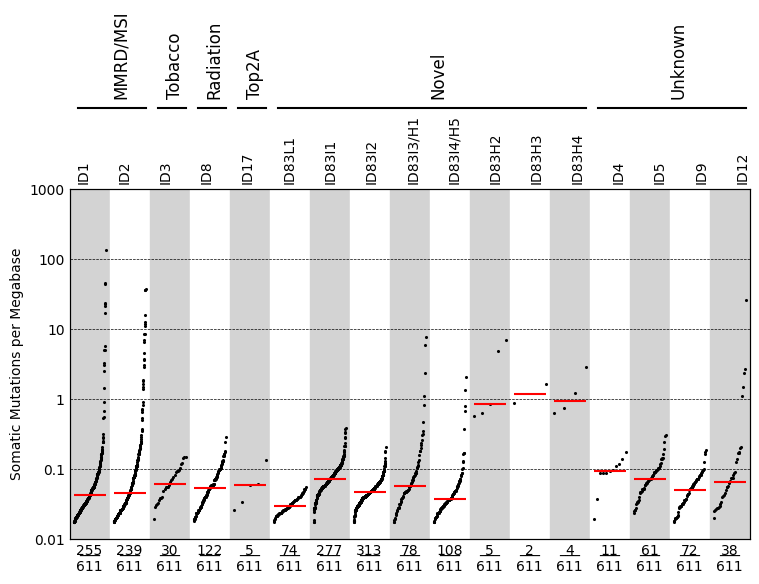

In [70]:
plotTMB_ID_v3(kzm611_id_mlt[['Signatures', 'Mutations']].copy(), kzm611_id_rel, order=id_order, scale='genome')
plt.savefig(os.path.join(fig_out, 'ExFig_4c_rev.pdf'), bbox_inches="tight")

-----
## Panel d

In [73]:
## Adapted from https://github.com/AlexandrovLab/SigProfilerPlotting
def plotTMB_SV_v3(inputDF, kzm611_sigs_rel, scale, order=[], Yrange = "adapt", cutoff = 0,
            redbar = "median", yaxis = "Somatic Mutations per Megabase",
            ascend = True, leftm = 1, rightm = 0.3, topm = 1.4, bottomm = 1):
    """
    Same as plotTMB_SBS
    """
    if type(scale) == int:
        scale = scale
    elif scale == "genome":
        scale  = 2897.310462
    elif scale == "exome":
        scale = 55
    else:
        print("Please input valid scale values: \"exome\", \"genome\" or a numeric value")
        return

    inputDF.columns = ['Types', 'Mut_burden']
    df=inputDF[inputDF["Mut_burden"] > cutoff].copy()
    df['log10BURDENpMB'] = df.apply(lambda row: np.log10(row.Mut_burden/scale), axis = 1)
    groups = df.groupby(["Types"])
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        if len(order) == 0:
            redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
            names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
        else:
            redbars = groups.median()["log10BURDENpMB"]
            redbars = redbars.loc[order]
            names = order
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return
    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups
    #second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]
    list1 = counts.to_list()
    list2 = input_counts.to_list()
    str1 = ''
    list3 = prepend(list1, str1)
    str2 = '\n'
    list4 = prepend(list2, str2)
    result = [None]*(len(list3)+len(list4))
    result[::2] = list3
    result[1::2] = list4
    tick_labels = result
    new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
    if Yrange == "adapt":
        ymax = math.ceil(df['log10BURDENpMB'].max())
        ymin = math.floor(df['log10BURDENpMB'].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        print("Yrange is a list")
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print("ERROR:Please input valid scale values: \"adapt\", \"cancer\" or a list of two power of 10 numbers")
        return
    #plotting
    if ngroups < 7:
        rightm = rightm + 0.4 * (7 - ngroups)
    if len(names[0])>13:
        leftm = leftm + 0.09 * (len(names[0]) - 13)
        topm = topm + 0.080 * (len(names[0]) - 13)
    fig_width = leftm + rightm + 0.4 * ngroups
    fig_length = 4
    fig, ax2 = plt.subplots(figsize=(fig_width, fig_length))

    ann_y = 1.13
    ax2.text(1, ann_y, 'HRD', fontsize=12, rotation=90)
    ax2.text(6.5, ann_y, 'Novel', fontsize=12, rotation=90)
    ax2.text(17.5, ann_y, 'Unknow', fontsize=12, rotation=90)

    line_y = 1.2
    trans = ax2.get_xaxis_transform()
    ax2.plot([.4, 1.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([2.4, 11.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([12.4, 23.8],[line_y,line_y], color="k", transform=trans, clip_on=False)

    if cutoff < 0:
        print("ERROR: cutoff value is less than 0")
        return
    ax2.set_xlim(0,2*ngroups)
    #print(len(names[0]))
    ax2.set_ylim(ymin,ymax)
    yticks_loc = range(ymin,ymax+1,1)
    ax2.set_yticks(yticks_loc,list(map((lambda x: 10**x), list(yticks_loc))))
    ax2.set_xticks(np.arange(1, 2*ngroups+1, step = 2), new_labels) 
    ax2.tick_params(axis = 'both', which = 'both',length = 0)
    ax2.hlines(yticks_loc,0,2*ngroups,colors = 'black',linestyles = "dashed",linewidth = 0.5,zorder = 1)

    for i in range(0,ngroups):
        if ((i+1) % 2) == 0:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color="white", zorder = 0)
            ax2.add_patch(rectangle)
        else:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color='lightgray', zorder = 0)
            ax2.add_patch(rectangle)
    for i in range(0,ngroups,1):
        X_start = i*2+0.2
        X_end = i*2+2-0.2
        #rg = 1.8
        y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
        x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
        ax2.scatter(x_values,y_values,color = "black",s=1.5)
        ax2.hlines(redbars[i], X_start, X_end, colors='red', zorder=2)
        ax2.text((leftm + 0.2 + i * 0.4) / fig_width , 0.85 / fig_length , "___",  horizontalalignment='center',transform=plt.gcf().transFigure)
    ax2.set_ylabel(yaxis)

    axes2 = ax2.twiny()
    plt.tick_params(axis = 'both', which = 'both',length = 0)
    plt.xticks(np.arange(1, 2*ngroups+1, step = 2),names,rotation = 90,ha = 'right')

    fig.subplots_adjust(top = ((ymax - ymin) * 0.7 + bottomm) / fig_length, bottom = bottomm / fig_length, left = leftm / fig_width, right=1 - rightm / fig_width)

In [29]:
sv_sigs = pd.read_csv('/Users/mehdi/Documents/MyRepos/mutsigs_drugs/source_data/KZM_SV32_sigs.txt', sep='\t', index_col=0)
sv_sigs.head(3)

,SV2,SV3,SV4,SV5,SV6,SV8,SV9,SV32A,SV32B,SV32C,SV32D,SV32E
Samples,,,,,,,,,,,,
KiCS0025_307284,11,0,0,0,0,12,0,0,0,0,0,20
zcc403,111,0,30,0,73,0,0,40,21,31,0,0
KiCS0079_19_7192,14,0,0,0,0,12,0,0,0,0,0,0


In [30]:
sv_sigs = sv_sigs.reset_index(drop=False)
sv_sigs_mlt = pd.melt(sv_sigs, id_vars=['Samples'], value_vars=sv_sigs.columns.tolist())
sv_sigs_mlt.columns = ['Samples', 'Signatures', 'Mutations']
sv_sigs_mlt['Treatment'] = [kzm611_md.loc[x, 'Therapy'] for x in sv_sigs_mlt.Samples]
sv_sigs_mlt.head()

,Samples,Signatures,Mutations,Treatment
0,KiCS0025_307284,SV2,11,Post-Therapy
1,zcc403,SV2,111,Post-Therapy
2,KiCS0079_19_7192,SV2,14,Post-Therapy
3,zcc248,SV2,3,Pre-Therapy
4,KiCS0106_302802,SV2,26,Post-Therapy


In [31]:
sv_sigs_mlt.Signatures.unique()

array(['SV2', 'SV3', 'SV4', 'SV5', 'SV6', 'SV8', 'SV9', 'SV32A', 'SV32B',
       'SV32C', 'SV32D', 'SV32E'], dtype=object)

In [32]:
sv_order = ['SV3',
            'SV32A', 'SV32B', 'SV32C', 'SV32D', 'SV32E',
            'SV2', 'SV4', 'SV5', 'SV6', 'SV8', 'SV9']

In [33]:
sv_sigs_piv = sv_sigs_mlt.pivot_table(values='Mutations', index='Signatures', columns='Treatment')
sv_sigs_piv = sv_sigs_piv.reindex(sv_order)
sv_sigs_rel = sv_sigs_piv.div(sv_sigs_piv.sum(axis=1), axis=0)
sv_sigs_rel = sv_sigs_rel[['Pre-Therapy', 'Post-Therapy']]
sv_sigs_rel.head()

Treatment,Pre-Therapy,Post-Therapy
Signatures,,
SV3,0.470566,0.529434
SV32A,0.309056,0.690944
SV32B,0.253735,0.746265
SV32C,0.256755,0.743245
SV32D,0.393034,0.606966


/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/130422576.py:109: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/130422576.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/130422576.py:112: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as lab

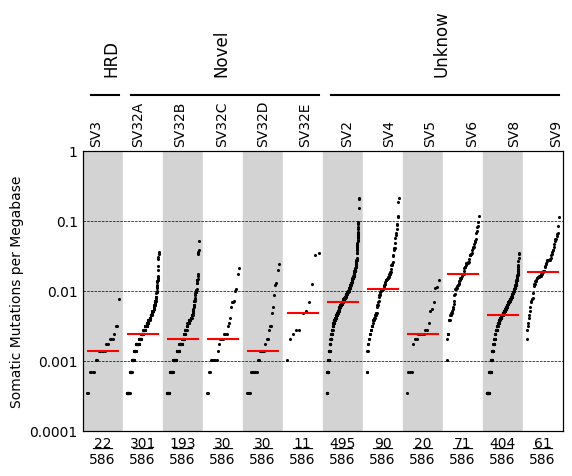

In [74]:
plotTMB_SV_v3(sv_sigs_mlt[['Signatures', 'Mutations']].copy(), sv_sigs_rel, order=sv_order, scale='genome')
plt.savefig(os.path.join(fig_out, 'ExFig_4d_rev.pdf'), bbox_inches="tight")

-----
## Panel e

In [81]:
## Adapted from https://github.com/AlexandrovLab/SigProfilerPlotting
def plotTMB_CN_v3(inputDF, kzm611_sigs_rel, scale, order=[], Yrange = "adapt", cutoff = 0,
            redbar = "median", yaxis = "Somatic Mutations per Megabase",
            ascend = True, leftm = 1, rightm = 0.3, topm = 1.4, bottomm = 1):
    """
    Same as plotTMB_SBS
    """
    if type(scale) == int:
        scale = scale
    elif scale == "genome":
        scale  = 2897.310462
    elif scale == "exome":
        scale = 55
    else:
        print("Please input valid scale values: \"exome\", \"genome\" or a numeric value")
        return

    inputDF.columns = ['Types', 'Mut_burden']
    df=inputDF[inputDF["Mut_burden"] > cutoff].copy()
    df['log10BURDENpMB'] = df.apply(lambda row: np.log10(row.Mut_burden/scale), axis = 1)
    groups = df.groupby(["Types"])
    if redbar == "mean":
        redbars = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend)
        names = groups.mean()["log10BURDENpMB"].sort_values(ascending=ascend).index
    elif redbar == "median":
        if len(order) == 0:
            redbars = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend)
            names = groups.median()["log10BURDENpMB"].sort_values(ascending=ascend).index
        else:
            redbars = groups.median()["log10BURDENpMB"]
            redbars = redbars.loc[order]
            names = order
    else:
        print("ERROR: redbar parameter must be either mean or median")
        return
    counts = groups.count()["log10BURDENpMB"][names]
    ngroups = groups.ngroups
    #second row of bottom label
    input_groups = inputDF.groupby(["Types"])
    input_counts = input_groups.count()["Mut_burden"][names]
    list1 = counts.to_list()
    list2 = input_counts.to_list()
    str1 = ''
    list3 = prepend(list1, str1)
    str2 = '\n'
    list4 = prepend(list2, str2)
    result = [None]*(len(list3)+len(list4))
    result[::2] = list3
    result[1::2] = list4
    tick_labels = result
    new_labels = [ ''.join(x) for x in zip(tick_labels[0::2], tick_labels[1::2]) ]
    if Yrange == "adapt":
        ymax = math.ceil(df['log10BURDENpMB'].max())
        ymin = math.floor(df['log10BURDENpMB'].min())
    elif Yrange == "cancer":
        ymax = 3
        ymin = -3
    elif type(Yrange) == list:
        print("Yrange is a list")
        ymax = int(math.log10(Yrange[1]))
        ymin = int(math.log10(Yrange[0]))
    else:
        print("ERROR:Please input valid scale values: \"adapt\", \"cancer\" or a list of two power of 10 numbers")
        return
    #plotting
    if ngroups < 7:
        rightm = rightm + 0.4 * (7 - ngroups)
    if len(names[0])>13:
        leftm = leftm + 0.09 * (len(names[0]) - 13)
        topm = topm + 0.080 * (len(names[0]) - 13)
    fig_width = leftm + rightm + 0.4 * ngroups
    fig_length = 4
    fig, ax2 = plt.subplots(figsize=(fig_width, fig_length))

    ann_y = 2
    ax2.text(0.9, ann_y, 'Tetraploidy', fontsize=12, rotation=90)
    ax2.text(2.7, ann_y, 'Octoploidy', fontsize=12, rotation=90)
    ax2.text(6.7, ann_y, 'Chromothripsis', fontsize=12, rotation=90)
    ax2.text(10.6, ann_y, 'LOH', fontsize=12, rotation=90)
    ax2.text(12.6, ann_y, 'dMMR', fontsize=12, rotation=90)
    ax2.text(20, ann_y, 'Novel', fontsize=12, rotation=90)
    ax2.text(26.7, ann_y, 'Unknown', fontsize=12, rotation=90)

    line_y = 1.16
    trans = ax2.get_xaxis_transform()
    ax2.plot([0.4, 1.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([2.4, 3.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([4.4, 9.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([10.4, 11.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([12.4, 13.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([14.4, 25.8],[line_y,line_y], color="k", transform=trans, clip_on=False)
    ax2.plot([26.4, 27.8],[line_y,line_y], color="k", transform=trans, clip_on=False)

    if cutoff < 0:
        print("ERROR: cutoff value is less than 0")
        return
    ax2.set_xlim(0,2*ngroups)
    #print(len(names[0]))
    ax2.set_ylim(ymin,ymax)
    yticks_loc = range(ymin,ymax+1,1)
    ax2.set_yticks(yticks_loc,list(map((lambda x: 10**x), list(yticks_loc))))
    ax2.set_xticks(np.arange(1, 2*ngroups+1, step = 2), new_labels) 
    ax2.tick_params(axis = 'both', which = 'both',length = 0)
    ax2.hlines(yticks_loc,0,2*ngroups,colors = 'black',linestyles = "dashed",linewidth = 0.5,zorder = 1)

    for i in range(0,ngroups):
        if ((i+1) % 2) == 0:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color="white", zorder = 0)
            ax2.add_patch(rectangle)
        else:
            rectangle = mpatches.Rectangle([(i)*2, ymin], 2, ymax-ymin, color='lightgray', zorder = 0)
            ax2.add_patch(rectangle)
    for i in range(0,ngroups,1):
        X_start = i*2+0.2
        X_end = i*2+2-0.2
        #rg = 1.8
        y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
        x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
        ax2.scatter(x_values,y_values,color = "black",s=1.5)
        ax2.hlines(redbars[i], X_start, X_end, colors='red', zorder=2)
        ax2.text((leftm + 0.2 + i * 0.4) / fig_width , 0.85 / fig_length , "___",  horizontalalignment='center',transform=plt.gcf().transFigure)
    ax2.set_ylabel(yaxis)

    axes2 = ax2.twiny()
    plt.tick_params(axis = 'both', which = 'both',length = 0)
    plt.xticks(np.arange(1, 2*ngroups+1, step = 2),names,rotation = 90,ha = 'right')

    fig.subplots_adjust(top = ((ymax - ymin) * 0.7 + bottomm) / fig_length, bottom = bottomm / fig_length, left = leftm / fig_width, right=1 - rightm / fig_width)


In [36]:
cn_sigs = pd.read_csv('/Users/mehdi/Documents/MyRepos/mutsigs_drugs/source_data/KZM_CN48_sigs.txt', sep='\t', index_col=0)
cn_sigs.head(3)

,CN2,CN3,CN4,CN5,CN7,CN13,CN20,CN25,CN48A,CN48B,CN48C,CN48D,CN48E,CN48F
Samples,,,,,,,,,,,,,,
zcc204,0,0,0,0,0,0,0,0,0,382,0,0,0,0
zcc65,0,0,0,0,0,22,18,0,0,0,0,0,0,0
KiCS0048_18_753,0,0,0,0,0,37,0,0,0,0,0,0,0,0


In [37]:
cn_sigs = cn_sigs.reset_index(drop=False)
cn_sigs_mlt = pd.melt(cn_sigs, id_vars=['Samples'], value_vars=cn_sigs.columns.tolist())
cn_sigs_mlt.columns = ['Samples', 'Signatures', 'Mutations']
cn_sigs_mlt['Treatment'] = [kzm611_md.loc[x, 'Therapy'] for x in cn_sigs_mlt.Samples]
cn_sigs_mlt.head()

,Samples,Signatures,Mutations,Treatment
0,zcc204,CN2,0,Post-Therapy
1,zcc65,CN2,0,Post-Therapy
2,KiCS0048_18_753,CN2,0,Post-Therapy
3,KiCS0069_298700,CN2,0,Pre-Therapy
4,zcc123,CN2,0,Post-Therapy


In [38]:
cn_sigs_mlt.Signatures.unique()

array(['CN2', 'CN3', 'CN4', 'CN5', 'CN7', 'CN13', 'CN20', 'CN25', 'CN48A',
       'CN48B', 'CN48C', 'CN48D', 'CN48E', 'CN48F'], dtype=object)

In [39]:
cn_order = ['CN2', 'CN3', 'CN4', 'CN5', 'CN7', 'CN13', 'CN25',
            'CN48A', 'CN48B', 'CN48C', 'CN48D', 'CN48E', 'CN48F',
            'CN20']

In [40]:
cn_sigs_piv = cn_sigs_mlt.pivot_table(values='Mutations', index='Signatures', columns='Treatment')
cn_sigs_piv = cn_sigs_piv.reindex(cn_order)
cn_sigs_rel = cn_sigs_piv.div(cn_sigs_piv.sum(axis=1), axis=0)
cn_sigs_rel = cn_sigs_rel[['Pre-Therapy', 'Post-Therapy']]
cn_sigs_rel.head()

Treatment,Pre-Therapy,Post-Therapy
Signatures,,
CN2,0.478727,0.521273
CN3,0.495537,0.504463
CN4,0.532528,0.467472
CN5,0.162909,0.837091
CN7,0.287740,0.712260


/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/1060639018.py:117: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  y_values = groups.get_group(names[i])["log10BURDENpMB"].sort_values(ascending = True).values.tolist()
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/1060639018.py:118: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_values = list(np.linspace(start = X_start, stop = X_end, num = counts[i]))
/var/folders/v_/5kvb1yw12gg5hlp_37y4c84w0000gp/T/ipykernel_20354/1060639018.py:120: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as 

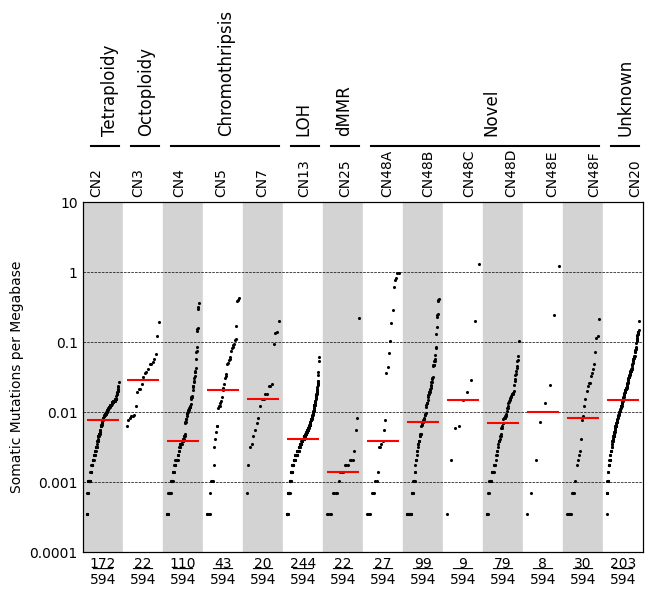

In [82]:
plotTMB_CN_v3(cn_sigs_mlt[['Signatures', 'Mutations']].copy(), cn_sigs_rel, order=cn_order, scale='genome')
plt.savefig(os.path.join(fig_out, 'ExFig_4e_rev.pdf'), bbox_inches="tight")

In [55]:

from importlib import reload
reload(plotter)

<module 'helper_functions.plotter' from '/Users/mehdi/Documents/MyRepos/mutsigs_drugs/helper_functions/plotter.py'>